<a href="https://colab.research.google.com/github/jfmra99/Redes_Neuronales/blob/master/Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SOLUCIÓN: clasificación de spam**

## **Introducción**
Se quiere ajustar dos modelos para clasificar mensajes de texto como spam o ham (mensaje veridico). Se ajustará una red neuronal y se le comparará con un modelo clásico (regresión logit).

## **Carga de librerias**

In [0]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Conjunto de datos**

Los datos se obtienen del [enlace](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/), se tienen 5574 datos reales de mensajes de SMS en inglés.

In [9]:
# Carga de la base
df = pd.read_csv(
    "https://github.com/ANN-2019-2/evaluacion-jfmra99/raw/master/03-spam-SOLUCI%C3%93N/sms_spam_Data.csv",
    sep = ',',
    encoding='UTF-8')

df

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


A continuación se puede apreciar en la tabla y el gráfico que la gran mayoría de los mensajes son reales (ham): 

In [6]:
df.groupby('type').count()

,text
type,
ham,4827
spam,747


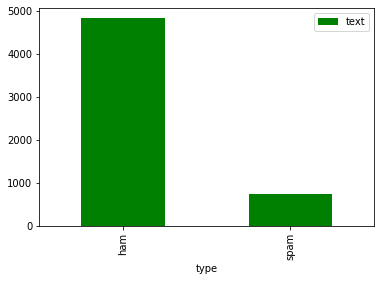

In [13]:
df.groupby('type').count().plot.bar(color = "green")

## **Pre-procesamiento de los datos**
Para ajustar los modelos, los textos de los mensajes se pre-procesan siguiendo la metodología utilizada en el ejemplo del profesor Juan David Velasquez, la cuall puede verse [aqui](https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html).

Primero se reducen los textos a su raíz grecolatina utilizando un **Stemmer**

In [14]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


Luego se crea  una matriz de terminos del documento. De manera que se contabilizan cuantas veces aparecen las palabras en los mensajes. De esta manera estas serviran para identificar que mensaje es spam en base a su frecuencia:

In [0]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

## lista de palabras registrada
vocabulary = count_vect.get_feature_names()



`dtm` es nuestra matriz de palabras, tendriamos 1574 terminos diferentes para los 5574 mensajes: 

In [17]:
dtm.shape

(5574, 1535)

Se define una función para recuperar los mensajes de la htm:

In [0]:
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

## Conjunto de prueba y validación
Se separa el conjunto de datos en dos partes, el 75% de los datos serán utilizados para el entrenamiento y el 25% para la validación:

In [0]:

##
## Creación de los conjuntos de entrenamiento y prueba.
##
indices = np.random.rand(5574) < 0.75

X_train      = dtm[indices,]
X_test       = dtm[~indices,]
y_train_true = df.type[indices]
y_test_true  = df.type[~indices]

Se verifica que la proporción de datos spam y reales sean similares en el conjunto de entrenamiento y validación.

In [63]:
print("Distribución de los datos en el conjunto de entrenamiento:")
print(round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1))
##
print("Distribución de los datos en el conjunto de validación:")
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

Distribución de los datos en el conjunto de entrenamiento:
ham     86.8
spam    13.2
Name: type, dtype: float64
Distribución de los datos en el conjunto de validación:


ham     86.0
spam    14.0
Name: type, dtype: float64

## Modelo logístico

Nuestro modelo de referencia será una regresión logit, por ser uno de los métodos más populares para clasificación:

In [70]:
base_model = LogisticRegression(random_state=420).fit(X_train, y_train_true)

accuracy_score(y_test_true, base_model.predict(X_test))

0.9749652294853964

Este tiene una precisión del 97.5% en el conjunto de validación. Y una matriz de confusión:

In [69]:
confusion_matrix(y_test_true, base_model.predict(X_test))

array([[1236,    1],
       [  35,  166]])

Con visualización porcentual:

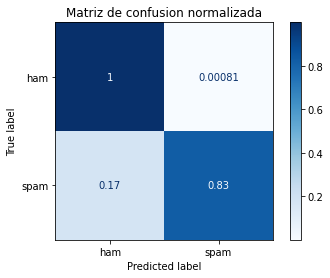

In [71]:
cm = plot_confusion_matrix(base_model, X_test, y_test_true,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')
cm.ax_.set_title("Matriz de confusion normalizada")
plt.show()

## Clasificación mediante red neuronal

Se consideran un clasificador de perceptrones para solucionar el problema, se utilizará `MLPClassifier`, el cual puede encontrarse en `sklearn.neural_network`. Se varian el número de neuronas en cada capa (de 1 a 5), el momentum entre los valores (0.1, 0.45, 0.6, 0.75, 0.9) y se utiliza una tasa de aprendizaje decreciente a lo largo del entrenamiento (con valor inicial 0.5).

El mejor modelo se elegira de su capacidad de reducir la precisión (aciertos/total_registros) en el conjunto de entrenamiento:

In [0]:
# Seguarda la precision para las graficas
N = dtm.shape[0]
#maximo numero de neuronal por capa
max_neur = 6

## Mejor modelo
best_model = None
acc_best_model = 0


best_moment = None

momentum = np.arange(0.1, 0.91, 0.15)

for h2_n in range(1, max_neur + 1):
  for h1_n in range(1, max_neur + 1):
    for mom in momentum:
      if(h1_n < h2_n):
        next

      percept = MLPClassifier(hidden_layer_sizes=(h1_n, h2_n),
          activation = 'logistic',
          solver = 'sgd',
          learning_rate = 'adaptive', #
          momentum = mom,
          learning_rate_init = 0.5,
          random_state = 11,
          max_iter = 1000
          )
      percept.fit(X_train, y_train_true)
      accuracy_mod = accuracy_score(y_test_true, percept.predict(X_test))

      if(accuracy_mod > acc_best_model):
        acc_best_model = accuracy_mod
        best_model = percept


In [62]:
acc_train = accuracy_score(y_train_true, best_model.predict(X_train))
print("El mejor modelo utilizó un momentum de", best_model.momentum, 
      " Sus dos capas ocultas tenian", best_model.hidden_layer_sizes, "capas ocultas.")

print("Además tuvo una precisión en los datos de entrenamiento de", acc_train, "y en los datos de validación de", acc_best_model)

El mejor modelo utilizó un momentum de 0.7  Sus dos capas ocultas tenian (5, 5) capas ocultas.
Además tuvo una precisión en los datos de entrenamiento de 0.999274661508704 y en los datos de validación de 0.9826147426981919


En este caso la matriz de confusión del mejor modelo para el conjunto de validación fue:

In [60]:
y_test_est = best_model.predict(X_test)
confusion_matrix(y_test_true, y_test_est)

array([[1230,    7],
       [  18,  183]])

Con visualización porcentual:

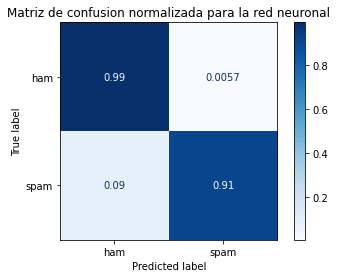

In [61]:
cm = plot_confusion_matrix(best_model, X_test, y_test_true,
     display_labels=['ham', 'spam'],
     cmap=plt.cm.Blues,
     normalize='true')

cm.ax_.set_title("Matriz de confusion normalizada para la red neuronal")
plt.show()

Se puede apreciar una mejoria general del modelo de redes neuronales frente a la regresión logística. Con una precisión mayor (aunque la del modelo logístico es bastante buena de por si). Particularmente se puede destacar que con la red neuronal se comete un error menor al clasificar mensajes de tipo spam disminuyendo en 8% la probabilidad de clasificarlos incorrectamente según los datos de entrenamiento, tal y como se puede apreciar en las matrices de confusión porcentuales (normalizadas). 
Sin embargo, el modelo de redes neuronales aumenta levemente la probabilidad de categorizar un mensaje ham como spam (alrededor del 0.5% según los datos de validación).